# <center>**MACHINE LEARNING**</center>
# <center>**Housing price prediction**</center>
## <center>**lacasademickeymouse**</center>

# Team

- Iñigo González-Varas Vallejo
- Eduardo De La Vega Fernández
- Juan Misas Higuera 
- Fernando Martín San Bruno

# Introduction

We will conduct a study on a regression problem focused on predicting housing prices. Initially, we will engage in data processing and analysis, which encompasses studying, transforming, removing, and aggregating the data provided for model training. Subsequently, we will test various regression models, including Linear Regression, RandomForestRegressor, ElasticNet, Lasso, Ridge, DecisionTreeRegressor, KNeighborsRegressor, GradientBoostRegressor, AdaBoostRegressor, and CatBoostRegressor. As a final step, we will search for the optimal hyperparameters by training models that achieve the best scores based on the evaluation metric for this problem.

# Imports

In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import pprint as pp
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import scipy.stats as stats
from catboost import CatBoostRegressor
import warnings
import datetime

warnings.filterwarnings('ignore')

# Functions

In this section, we outline the functions to be used throughout the notebook. Fundamentally, these functions can be categorized into the following classes:

Visualization functions (distributions, scatter plots, correlation matrix, performance on the test set)

Data preprocessing functions (encoding, normalization, data splitting)

**VISUALIZATION FUNCTIONS**

- **visualize_dataframe_distributions(df)**: This function visualizes the distribution of all columns within a DataFrame. It displays plots for numerical, categorical, and date/time columns in a grid format.

- **plot_correlation_matrix(df)**: Provides a colorized visualization of the DataFrame's correlation matrix, making it easier to discern relationships between variables.

**DATA PREPROCESSING FUNCTIONS**

- **minmax_norm(df, real_variables)**: Takes specified numerical columns and normalizes them between 0 and 1 using Min-Max normalization.

- **zscore_norm(df, real_variables)**: Applies Z-Score normalization to specified numerical columns, centering and scaling the data based on its mean and standard deviation.

- **one_hot_encoding(df, categorical_variables)**: Transforms categorical columns into a set of binary columns. This is especially useful for models that can't directly handle categorical variables.

- **extract_postal_hierarchy(df)**: Extracts hierarchies from a postal code column, creating new columns that denote postal groups and regions based on the codes.

- **zscore_norm_price(df)**: Specifically targets the 'Price' column, normalizing it using Z-Score, whereas zscore_norm_price_inverse(np_array) performs the reverse operation, denormalizing an array of prices.

- **x_y_split(df, target)**: Divides a DataFrame into a set of independent variables and a target variable, getting it ready for modeling.

- **train_model and test_model**: These are used for training models with data and subsequently testing their performance."

In [2]:
price_mean = 0
price_std = 0

def visualize_dataframe_distributions(df):
    # Filtrar columnas por tipo de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Numero total de columnas
    side_length = int(np.ceil(np.sqrt(n)))  # Calcula la longitud del lado de la cuadrícula
    
    # 
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[0:2]
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

def plot_correlation_matrix(df):
    corr = df.corr()
    corr = abs(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualize_test(y_test, y_pred, ax, model_name):
    perc_diff = abs((y_pred - y_test) / y_test) * 100
    sorted_indexes = np.argsort(perc_diff)[::-1] 
    
    y_test_sorted = y_test.iloc[sorted_indexes]
    y_pred_sorted = y_pred[sorted_indexes]
    
    # paired = sorted(list(zip(y_test, y_pred)))
    # y_test_sorted, y_pred_sorted = zip(*paired)

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)

    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))

    num_range = np.arange(0, len(y_test))
    ax.plot(num_range, y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(num_range, y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()
    
    return sorted_indexes


def plot_against_precio(df):
    """
    Plot all columns in dataframe df against 'Precio'.
    Assumes that 'Precio' is one of the columns in df.
    """
    # Ensure that Seaborn's aesthetics are being used
    sns.set(style="whitegrid")
    
    # Number of columns to be plotted against 'Precio'
    n = df.shape[1] - 1  # subtract 1 because we won't plot 'Precio' against itself
    
    # Create subplots; You can adjust the size (e.g., figsize) as per your requirements
    fig, axes = plt.subplots(n, 1, figsize=(8, 5*n))
    
    # For every column other than 'Precio', plot it against 'Precio'
    for i, column in enumerate([col for col in df.columns if col != 'Precio']):
        sns.scatterplot(data=df, x='Precio', y=column, ax=axes[i])
        axes[i].set_title(f'{column} vs. Precio')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


def visualize_price_distribution(df, column_name="Precio", title="Price Distribution", color="skyblue", kde=True):
    
    # Check if the column exists in the dataframe
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the dataframe!")
        return
    
    # Set the style for a fancier look
    sns.set(style="whitegrid")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=kde, color=color, bins=30, edgecolor="black", linewidth=0.5)
    
    # Decorate the plot
    plt.title(title, fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



# Procesamiento de datos

In this section of the notebook, we outline the data processing pipeline that we've found most effective for this problem and for training our models. This pipeline specifies the transformations that will be applied to the data prior to training the models, such as normalization, removal of less relevant columns, creation of new columns derived from existing ones, and so on.

In essence, this notebook captures the final solution we adopted for training our ultimate models. It also encapsulates various transformations that we experimented with but eventually chose not to implement. The entire process has been iterative, characterized by detailed data analysis and model testing. Throughout this journey, we've explored diverse transformations and models, and have prudently phased out those that didn't yield satisfactory results.

We start by importing the data and performing some basic analysis.

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


We can see that the dataset comprises 31 columns and 1,000 rows. The 'Precio' column represents our target variable, whereas the remaining columns serve as independent variables that can be leveraged to predict the property's price. Notably, the 'Id' column is an exception, as it simply provides a unique identification for each property.

In [4]:
columns = df.columns
rows = len(df)
print('Number of rows:', rows)
print('Number of columns:', len(columns))
print(columns)


Número de filas: 1000
Número de columnas: 31
Index(['Id', 'Tipo', 'FechaConstruccion', 'FechaReforma', 'Plantas', 'Plan',
       'PAU', 'CatParcela', 'PerimParcela', 'Superficie', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'Formato', 'TipoDesnivel', 'Desnivel', 'GasNatural',
       'AguaCorriente', 'FosaSeptica', 'Situacion', 'CP', 'ProxCarretera',
       'ProxCallePrincipal', 'ProxViasTren', 'Estado', 'RatingEstrellas',
       'Precio'],
      dtype='object')


Upon examining the dataset for null values, we observed that the columns 'Plan' and 'Parcela' contain them. We've decided to remove these columns, as they don't provide significant information for our analysis.

In [5]:
#look for nan value
nans = df.isna().sum()
nans = nans[nans > 0]
print(nans)

Plan            233
PerimParcela    173
dtype: int64


Next, we set the 'Id' column as the dataframe index and begin to remove columns that don't provide meaningful information for the analysis:

- **AguaCorriente, FosaSeptica, and GasNatural**: Almost all properties have these services, with only one exception, thus, they don't provide significant insight.
- **Piscina**: After conducting a correlation analysis with the price, we found that there isn't a significant relationship between the two variables, and only a few samples have a swimming pool.
- **Plan and Parcela**: As previously mentioned, these columns contain a substantial number of null values and don't offer meaningful information.


In [6]:
df.set_index('Id', inplace=True)
df.drop(['AguaCorriente', 'GasNatural', 'FosaSeptica', 'Piscina', 'Plan', 'PerimParcela'], axis=1, inplace=True)

After removing the aforementioned columns, we will first address the columns with numeric values (both integers and decimals).

**Postal Code**  
The postal code is a feature that can provide valuable information about the property since it helps identify the area in which it's located. However, postal codes are categorical in nature, meaning we can't directly use them in regression models. To leverage them, we split the postal code into two separate columns: **PostalGroup** and **PostalRegion**. The former captures the first digit of the postal code, while the latter comprises the first two digits. By doing this, we can treat these columns as categorical variables in our model and determine if there's a correlation between the property's location and its price.

In [7]:
df = extract_postal_hierarchy(df)

**Synthetic Variables**  
From the existing columns, we aim to craft new ones that encapsulate relevant information for the analysis and interactions between input variables. Throughout the project, we introduced several columns that we later opted not to use either because they introduced noise or were irrelevant for our models. These variables are commented out at the bottom of the cell. The columns we introduced include:

- **Used in the final model**
    - NoGarage: the inverse of the Garage column, i.e., if the property doesn't have a garage, it's set to 1, and if it does, it's set to 0.
    - 3floors: indicates if the house has 3 floors since it correlates with a lower price.
    - AgeOfHouse and YearsSinceReform: specify the house's age and the time elapsed since the last reform, respectively.
    
- **Interactions between variables used in the final model**: we introduced columns representing the interaction between input variables that have a significant correlation with the price.
    - bathrooms+rooms*rating: column crafted from variables that are most correlated with the price.
    - synth4-7: synthetic variables drawn from the mix of input columns. These result in distributions with a high correlation with the price, exhibiting linear and "banana" shaped (exponential curve) forms.

- **Not used in the final model**
    - Refurbished: whether the house is refurbished or not.
    - TotalRooms: total number of rooms.
    - AvgProximity: the average among variables related to distance to the highway, main street, and train tracks.


In [8]:
current_year = datetime.datetime.now().year

df['SinGaraje'] = df['Garaje'].apply(lambda x: 1 if x == 0 else 0)
df['3plantas'] = df['Plantas'].apply(lambda x: 1 if x == 3 else 0)
df['AgeOfHouse'] = current_year - df['FechaConstruccion']
df['YearsSinceReform'] = current_year - df['FechaReforma']
df['aseos+hab*rating'] = (0.7*df['Aseos'] + 0.3*df['Habitaciones']) * df['RatingEstrellas']
df['synth4'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'])
df['synth5'] = np.log1p(df['aseos+hab*rating'] * df['Estado'])
df['synth6'] = np.log1p(df['Estado'] * df['Superficie'])
df['synth7'] = np.log1p(df['aseos+hab*rating'] * df['Superficie'] * df['Estado'])

# df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
# df['Reformada'] = df['Reformada'].astype(int)
#df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
#df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3
#df['rooms/rating'] = df['Habitaciones'] / df['RatingEstrellas']

Following the correlation analysis and after having trained several models such as linear regression (in reality, this is an iterative process where we moved from subsequent cells to previous ones), we chose to drop the columns that didn't provide pertinent information for the analysis. This includes columns that had minimal importance in linear regression or whose information was already encapsulated in one of the previously crafted variables (due to high correlation with other variables).

In [9]:
df.drop(['FechaConstruccion', 'FechaReforma', 'Garaje', 'Formato', 'TipoDesnivel', 'Desnivel', 'Situacion', 'Plantas', 'PAU', 'Vallada', 'Callejon', 'CallePavimentada', 'Aseos', 'Habitaciones'], axis=1, inplace=True)

We perform one-hot encoding on all the categorical variables. Just as we did in the previous step, we eliminate those that aren't pertinent for our models and retain the rest.

In [10]:
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
df = one_hot_encoding(df, variables_categoricas)
df.drop(['Tipo_Chalet individual', 'CatParcela_Residencial tipo 2', 'CatParcela_Residencial unifamiliar', 'CP_50012', 'CP_50018', 'CP_60645', 'CP_61704', 'CP_62451'], axis=1, inplace=True)

We obtain the real and integer variables (float and int) and normalize them using Z-Score normalization (centering and scaling the data according to its mean and standard deviation). We don't apply this to the price since it has more associated issues (outliers, non-normal distribution, etc.) which we will address later on.

In [11]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_enteras = df.columns[df.dtypes == 'int64']
variables_enteras = variables_enteras.drop('Precio')
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)

In this cell, we showcase the functions used to visualize data distributions and relationships between variables. Here are some of the main functions we employed:

1. **visualize_dataframe_distributions**: 
    - This function displays distributions for all the variables in the dataset. It's especially useful to understand the distribution and spread of data.

2. **plot_against_precio**: 
    - This function produces plots for individual variables against the 'Precio' (Price) to visualize how each variable relates or correlates with the price. 

3. **sns.pairplot**: 
    - From the Seaborn library, this function creates a grid of Axes such that each variable in the dataset will be shared across the y-axes in a single row and the x-axes in a single column. It's a quick way to see relationships between pairs of variables.

By visualizing the data, we can better understand the underlying patterns and relationships, which can guide our preprocessing and modeling steps.


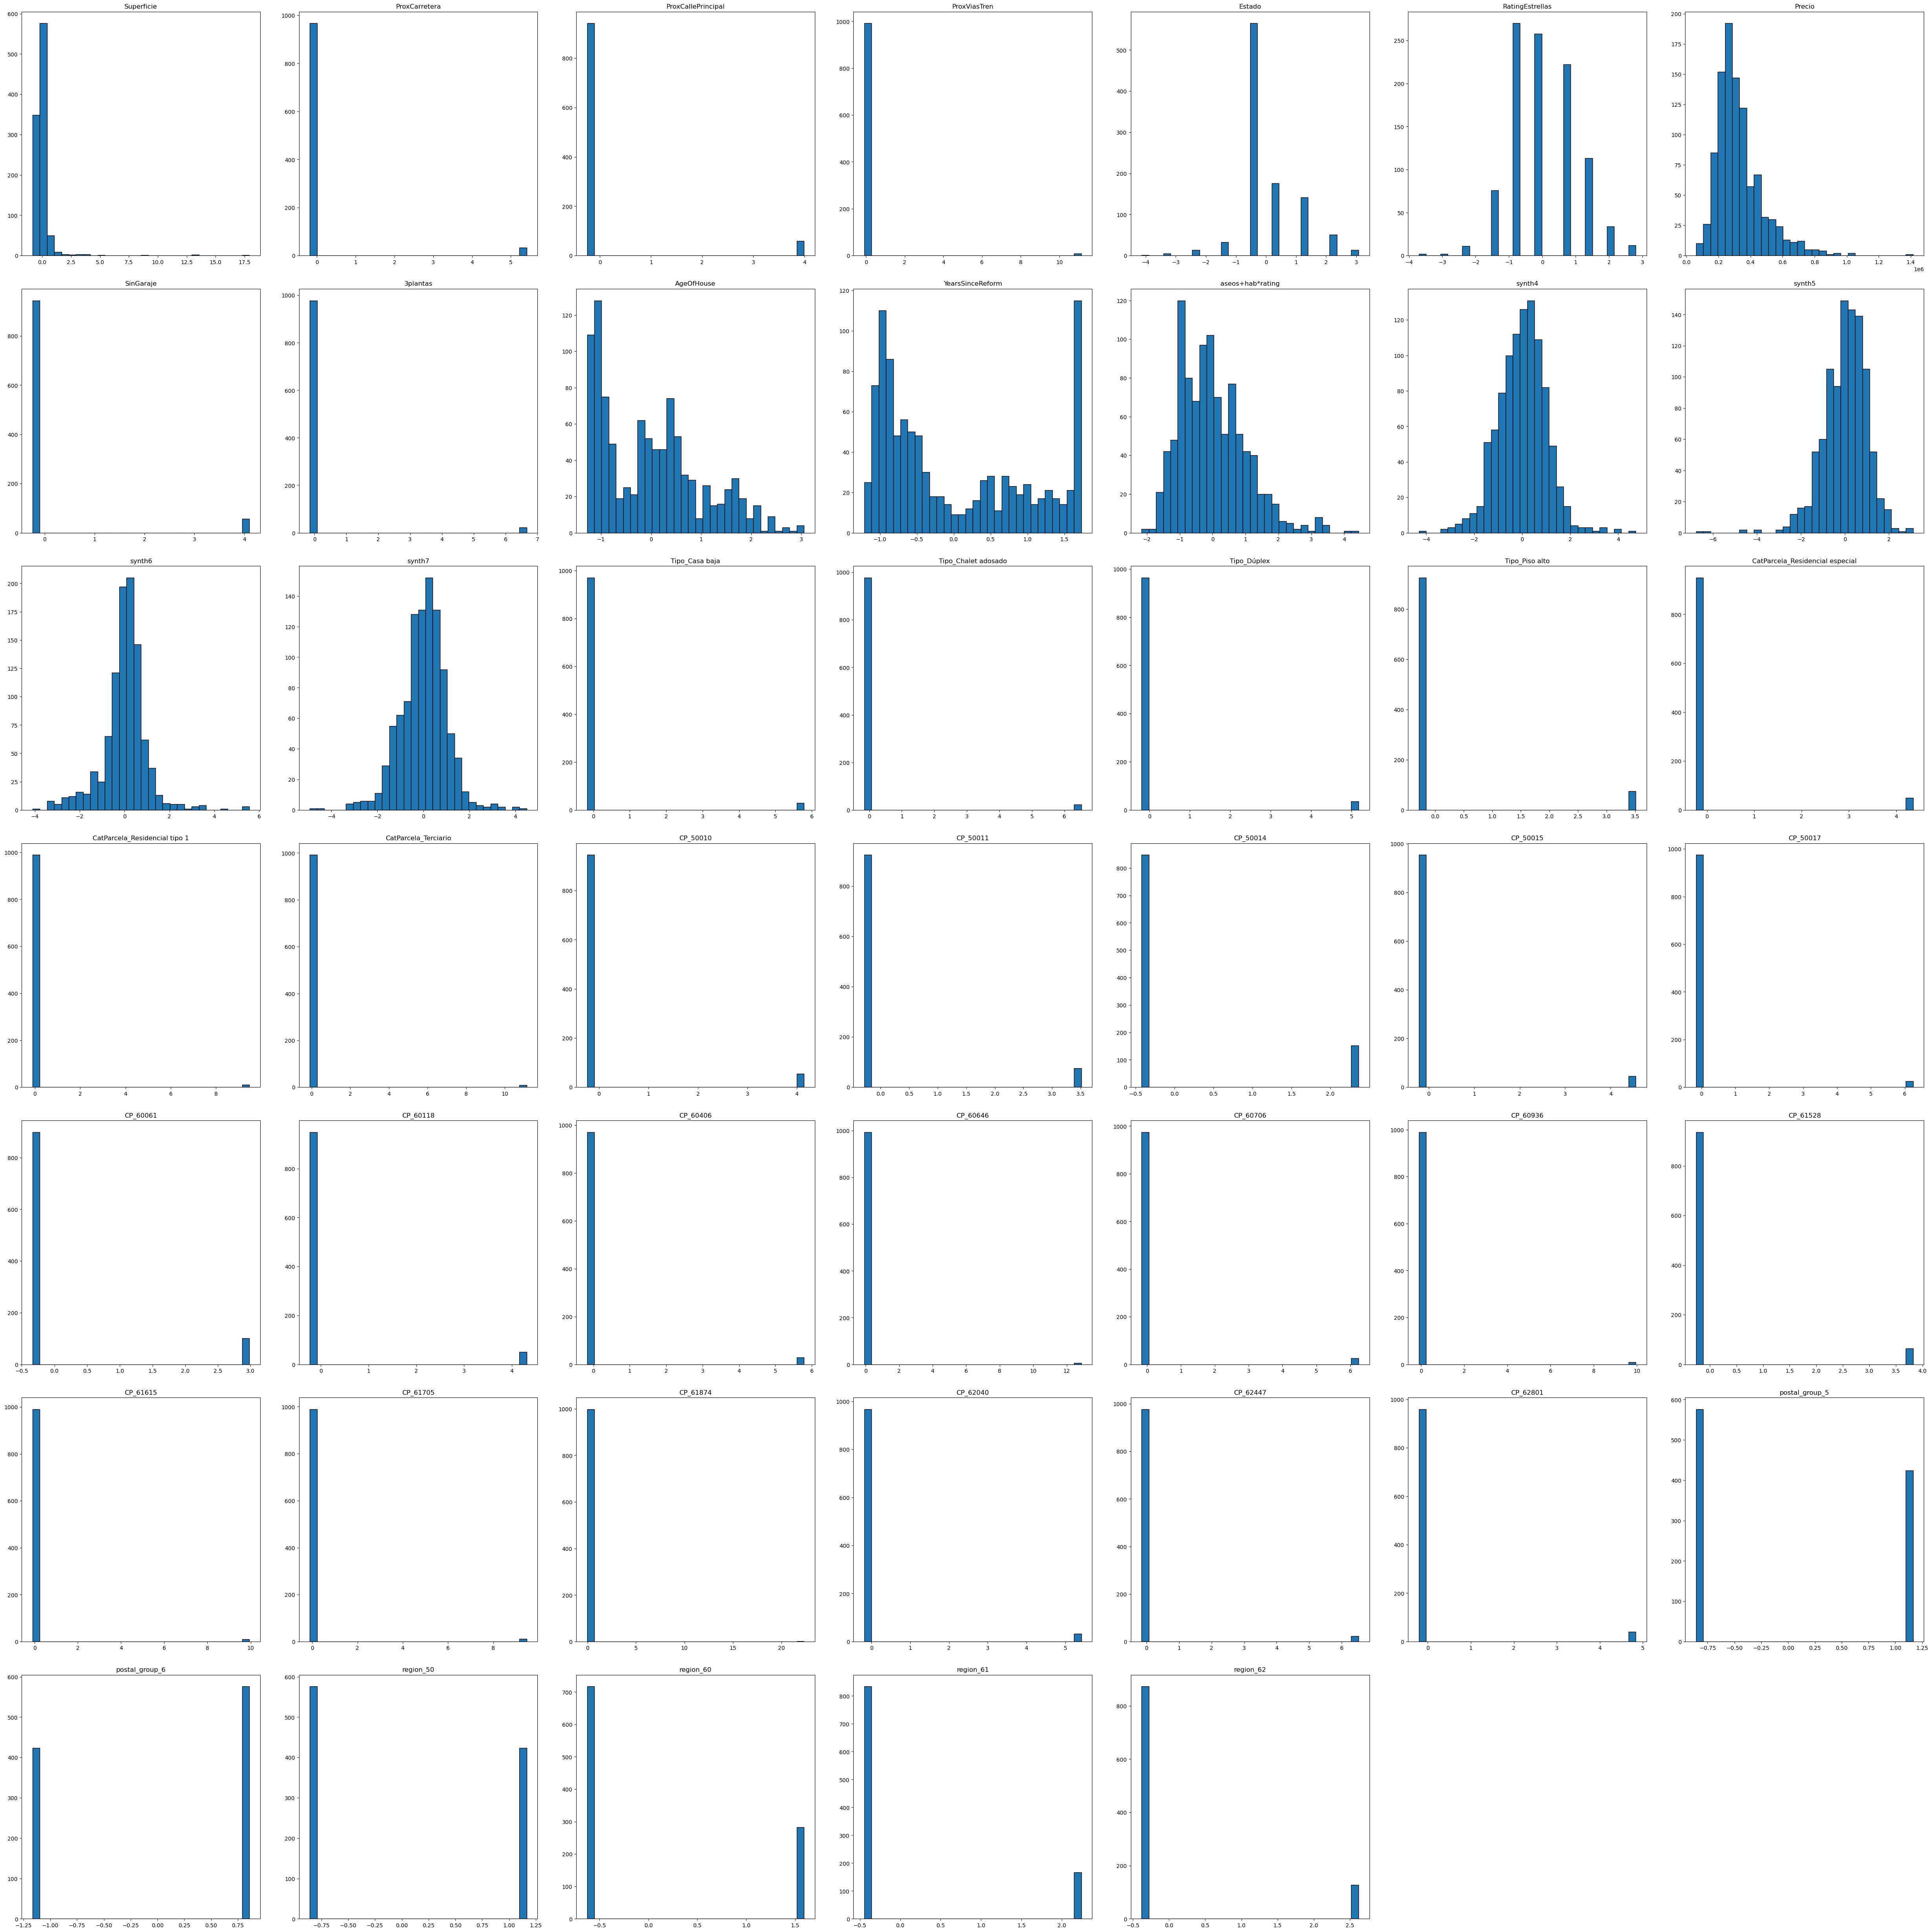

In [12]:
visualize_dataframe_distributions(df)
#sns.pairplot(df)
#plot_against_precio(df)

# Display the plots
plt.show()

At one point during our analysis, we considered addressing the skewness in some columns by applying a logarithmic transformation. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Transforming skewed data can sometimes lead to better performance in linear models. 

The approach was as follows:

1. **Detect Skewness**:
    - Using a function from `scipy.stats`, we identified columns that exhibited a significant skew.

2. **Log Transformation**: 
    - For columns with skewness, a logarithmic transformation was applied in an attempt to make the distribution more normal-like.

3. **Handle Problematic Values**: 
    - After the transformation, any infinite values were removed to ensure the data remained valid for modeling.

4. **Normalization**: 
    - After handling skewness and removing problematic values, the data was further normalized.

Despite these efforts, initial tests with our models indicated that this transformation did not enhance the model's performance. Consequently, we decided against its application. Nonetheless, we retained the code in the subsequent cell, providing us the option to revisit this approach in future analyses.

In [13]:
# from scipy.stats import skew
# numeric_features = df.dtypes[df.dtypes != object].index
# numeric_features = numeric_features.drop('Precio')
# skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
# high_skew = skewed_features[skewed_features > 0.5]
# skew_index = high_skew.index

# # Normalize skewed features using log_transformation
    
# for i in skew_index:
#     df[i] = np.log1p(df[i])

# inf=pd.DataFrame(np.isinf(df).sum() ,columns=['Inf_sum'])
# inf['feat']=inf.index
# inf=inf[inf['Inf_sum']>0]
# inf=inf.sort_values(by=['Inf_sum'])
# inf.insert(0,'Serial No.',range(1,len(inf)+1))
# print(inf)

The correlation matrix is an essential tool for exploratory data analysis, as it provides a comprehensive view of how each variable relates to the others.

**How to interpret the matrix?**

- The matrix values range between -1 and 1. The closer the value is to 1 (or -1), the stronger the positive (or negative) relationship between the two variables.
- A value close to 0 indicates a weak or non-existent correlation between the variables.
  
**Colors**:
- **Dark Blue**: Represents a correlation close to 0, indicating no strong relationship between the variables.
- **Dark Red**: Represents a correlation near 1 or -1, indicating a strong relationship between the variables. Specifically, a positive dark red indicates a positive correlation, while a negative dark red indicates a negative correlation.

**Importance in the analysis**:
This analysis helps us understand:
1. The relationships between different variables and how they might affect the price. 
2. If there are variables highly correlated with each other, which could be a sign of multicollinearity, something to avoid in linear regression models.

With the provided function below, we'll be able to visualize and intuitively understand these correlations among the dataset's different variables.


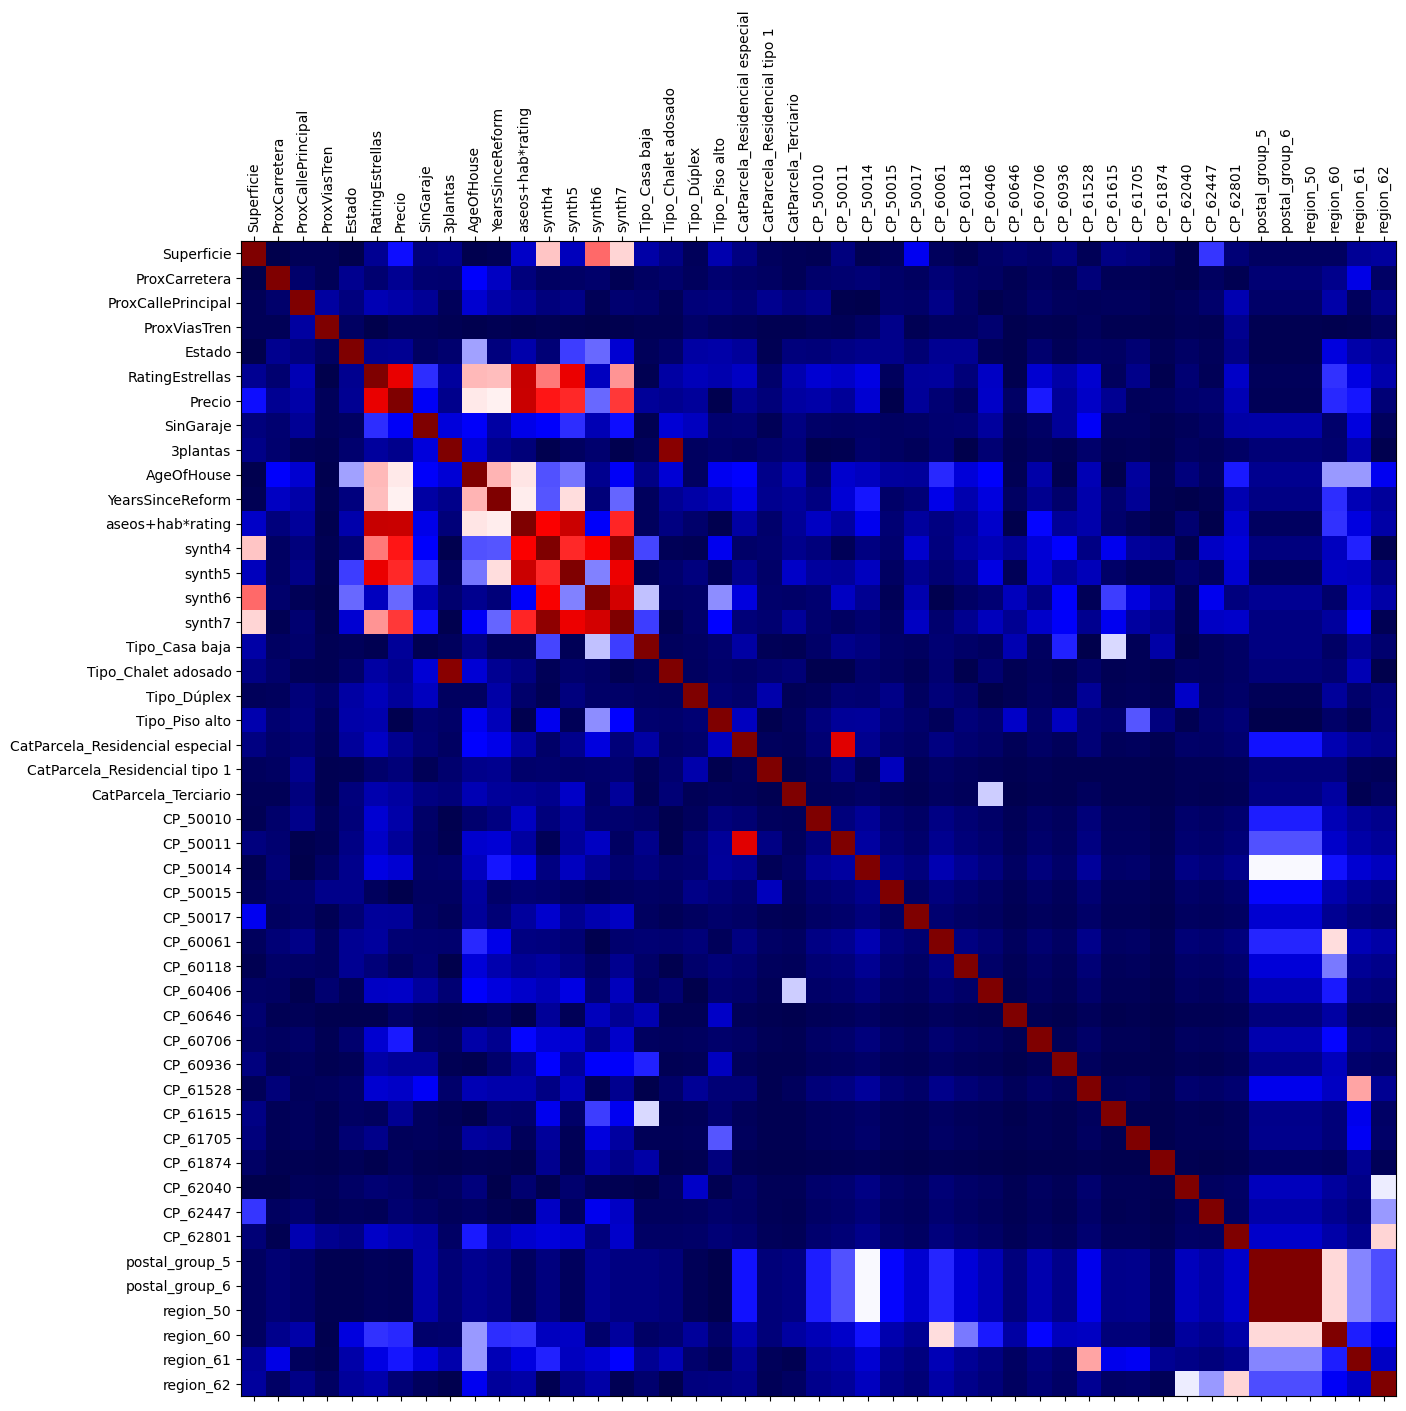

In [14]:
plot_correlation_matrix(df)

Using the values obtained from the correlation matrix, we have conducted various tests by discarding predictor variables that had a high correlation (exceeding a certain threshold we adjusted throughout the process). These variables could potentially introduce noise into the model, hindering the training process.

In [15]:
# corr = df.corr()
# umbral = 0.5
# # Encontrar características altamente correlacionadas
# caract_alta_correlacion = set()
# for i in range(len(corr.columns)):
#     for j in range(i):
#         if abs(corr.iloc[i, j]) < umbral:
#             colname = corr.columns[i]
#             caract_alta_correlacion.add(colname)
# caract_alta_correlacion.remove('Precio')
# print(caract_alta_correlacion)

# Price: Distribution and associated problems

Understanding the distribution of the target variable is essential as it informs us if any data transformation is required. In this case, we can observe that the price distribution is not normal. Instead, it has a long tail to the right (right-skewed). This skewness can pose challenges for models, potentially complicating regression in many instances.

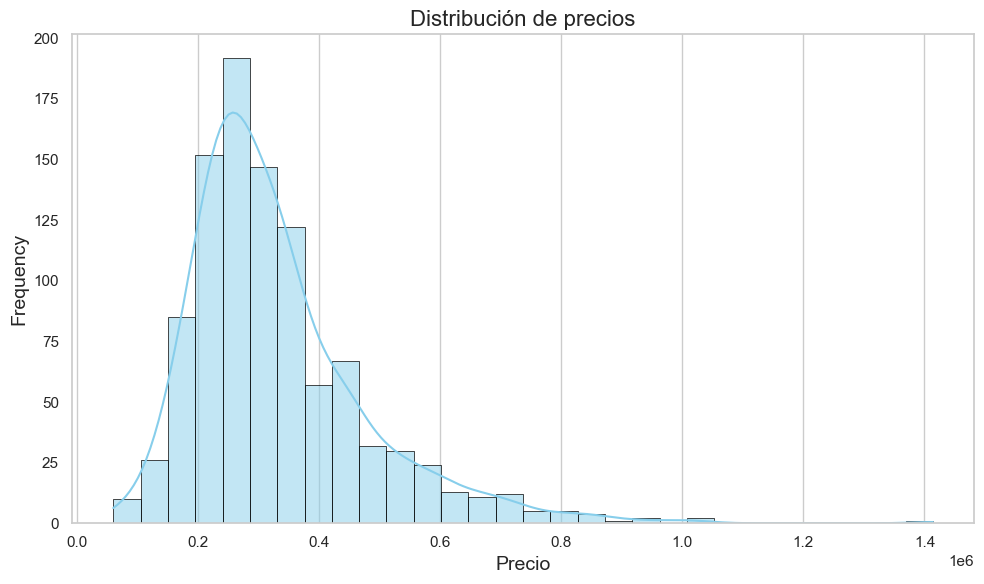

In [16]:
visualize_price_distribution(df, title="Distribución de precios")

To address this challenge, we've tested various potential solutions. Below, we enumerate solutions we've tried but did not include in our final model, as well as those we did. These solutions are based on various articles and literature that we've referenced in the bibliography.

- **Smogn (smote)**: SMOTE stands for Synthetic Minority Over-sampling Technique. It's an algorithm used to tackle the class imbalance problem in machine learning datasets. While SMOTE is typically available only for classification problems, researchers from the University of Porto have developed 'smogn', a variant for regression. Although it's considered state-of-the-art for treating imbalances in regression, it didn't yield satisfactory results for us.

  
- **Distribution Modification**: We attempted a sampling technique that modifies the data distribution to more closely resemble a normal distribution. However, this technique didn't produce desirable results, as it drastically altered the original distribution and complicated the learning process.
  
 
- **Outlier Removal**: Given the data's distribution, we tried removing values at the distribution's tail, specifically those above 1M in price. This technique proved effective, and we've incorporated it into our final model. Initially, we also removed surface values exceeding a certain threshold, but this worsened our results.
  

- **Logarithmic Transformation**: Log-transforming the price variable and then denormalizing has shown promising results in predicting housing prices. This is because the data's distribution becomes more normal-like after this transformation.
  
 
- **Bootstrap**: Bootstrap is less sensitive to peculiarities of a specific distribution and can provide more robust estimates in the presence of skewness.



In [17]:
#----------------------------------------
# SMOGN
#----------------------------------------
# from smogn import smoter
# df = smoter(data=df, y='Precio', k = 5, pert = 0.5, samp_method = 'balance')

#----------------------------------------
# Modificación de la distribución de precios
#----------------------------------------

#Calculate the number of bins
# num_bins = 10
# bins = np.linspace(train['Precio'].min(), train['Precio'].max(), num_bins+1)
# mid_points = (bins[:-1] + bins[1:]) / 2

# # Bin the data
# train['binned'] = pd.cut(train['Precio'], bins=bins)
# print(train['binned'].value_counts())
# # Desired normal distribution parameters
# mean = train['Precio'].mean()
# std = train['Precio'].std()

# # Calculate the desired number of samples per bin based on normal distribution
# pdf_values = stats.norm.pdf(mid_points, mean, std)
# desired_samples_per_bin = pdf_values / sum(pdf_values) * len(train)
# print(desired_samples_per_bin)

# # Get unique bin categories
# unique_bins = train['binned'].cat.categories

# # Oversample each bin
# oversampled_dfs = []

# for i, bin_category in enumerate(unique_bins):
#     bin_df = train[train['binned'] == bin_category]
#     num_samples = int(desired_samples_per_bin[i])

#     if not bin_df.empty and num_samples > 0:
#         oversampled_dfs.append(bin_df.sample(num_samples, replace=True))

# if oversampled_dfs:
#     oversampled_train = pd.concat(oversampled_dfs, axis=0).reset_index(drop=True)
#     # Drop the 'binned' column
#     oversampled_train = oversampled_train.drop(columns=['binned'])
# else:
#     print("No bins met the criteria for oversampling.")

# Training

Next, the dataset is split into training and test samples, with proportions of 80% for training and 20% for testing. We also set the random seed to ensure reproducibility.

In [18]:
train_size = 0.8
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

Ultimately, in our training test, the combination of solutions we've applied to enhance prediction is based on trimming the tails of the price distribution, bootstrapping the training samples, and applying a logarithmic transformation to normalize the data and slightly modify the shape of its distribution.

In [19]:
#----------------------------------------
# Outlier removal
#----------------------------------------

train = train[train['Precio'] < 10**6]
#train = train[train['Superficie'] < 3]
#train['Superficie'] = np.log1p(train['Superficie'])

#----------------------------------------
# Bootstrap
#----------------------------------------

n_iterations = 100  # number of bootstrap samples you want to create
bootstrap_samples = []

for i in range(n_iterations):
    bootstrap_sample = train.sample(n=len(train), replace=True)
    bootstrap_samples.append(bootstrap_sample)

train = pd.concat(bootstrap_samples, axis=0).reset_index(drop=True)

#----------------------------------------
# Normalization
#----------------------------------------

train['Precio'] = np.log1p(train['Precio'])

#----------------------------------------
# Target Variable separetion
#----------------------------------------

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')

## Linear regression: our baseline

We will use linear regression as a baseline to compare the performance of other models. In this case, we utilize the linear regression from scikit-learn, which is an implementation of linear regression with L2 regularization. Indeed, given these conditions, we'll observe that linear regression is one of the models that performs best for this problem.

**Metrics**  
The metrics used to assess the performance of our models will be two: MAE and MAPE. They allow for comparing the performance of models regardless of the scale of the data and are easily interpretable.
- MAE (Mean Absolute Error): This represents the average of the absolute differences between the actual and predicted values.
- MAPE (Mean Absolute Percentage Error): It represents the average of the absolute percentage differences between the actual and predicted values.


MAE: 40.475939659334415
MAPE: 12.01


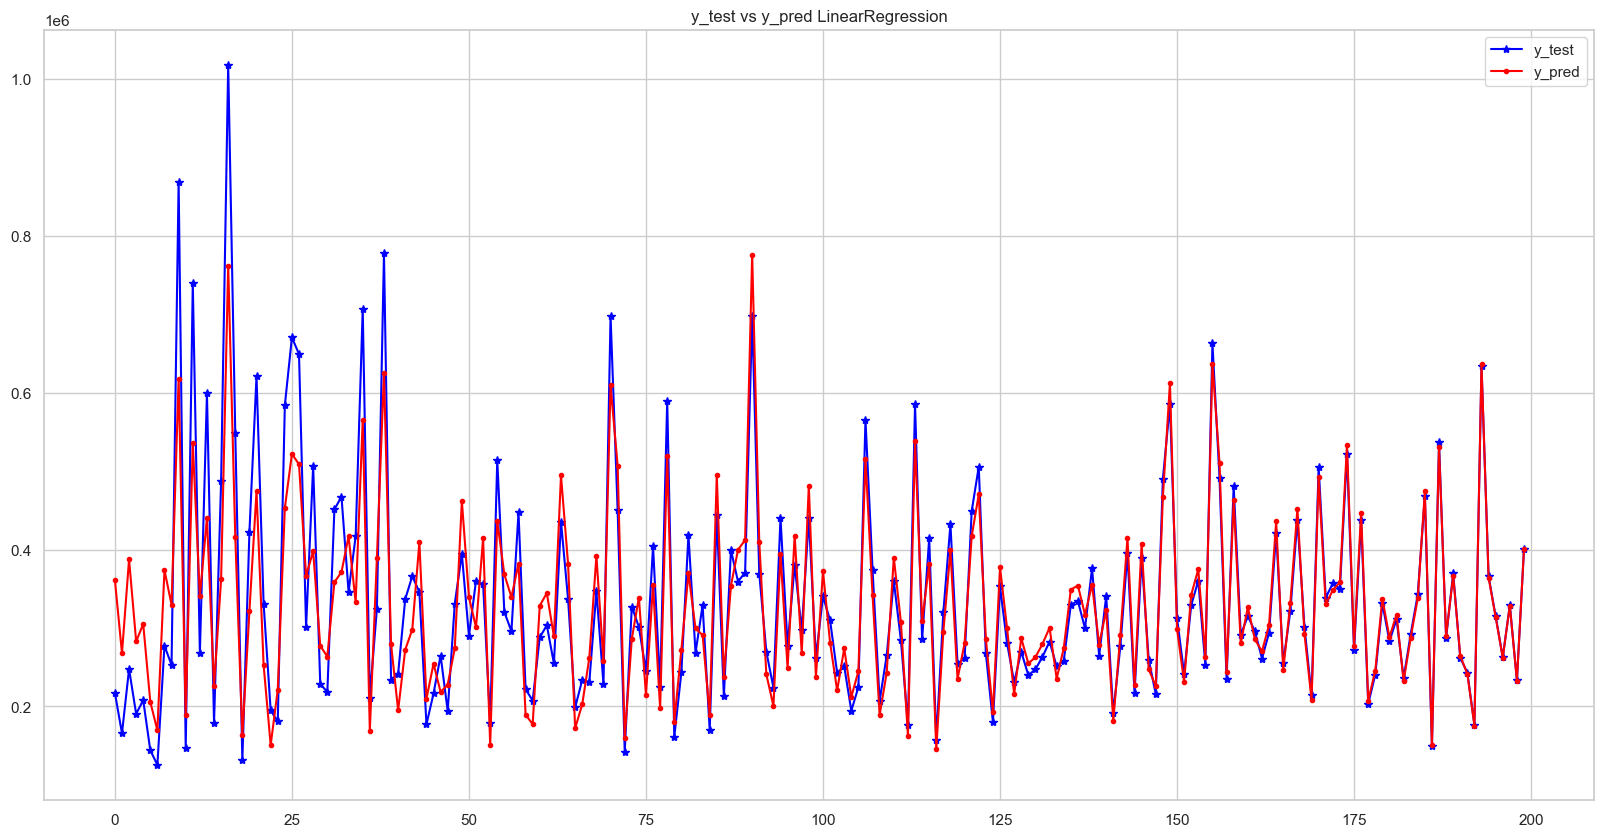

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)

y_pred = np.expm1(y_pred)

indexes = visualize_test(y_test, y_pred, ax=axes, model_name='LinearRegression')

It's crucial to analyze the samples where the biggest errors occur, as this helps identify scenarios where the model underperforms. To do this, we retrieve the samples sorted by absolute error and save them in a dataframe for further analysis. This step has been pivotal in our model training process and results evaluation, as it enabled us to pinpoint instances where the models falter and take corrective actions.

MAE: 39.64162071331019
MAPE: 11.48


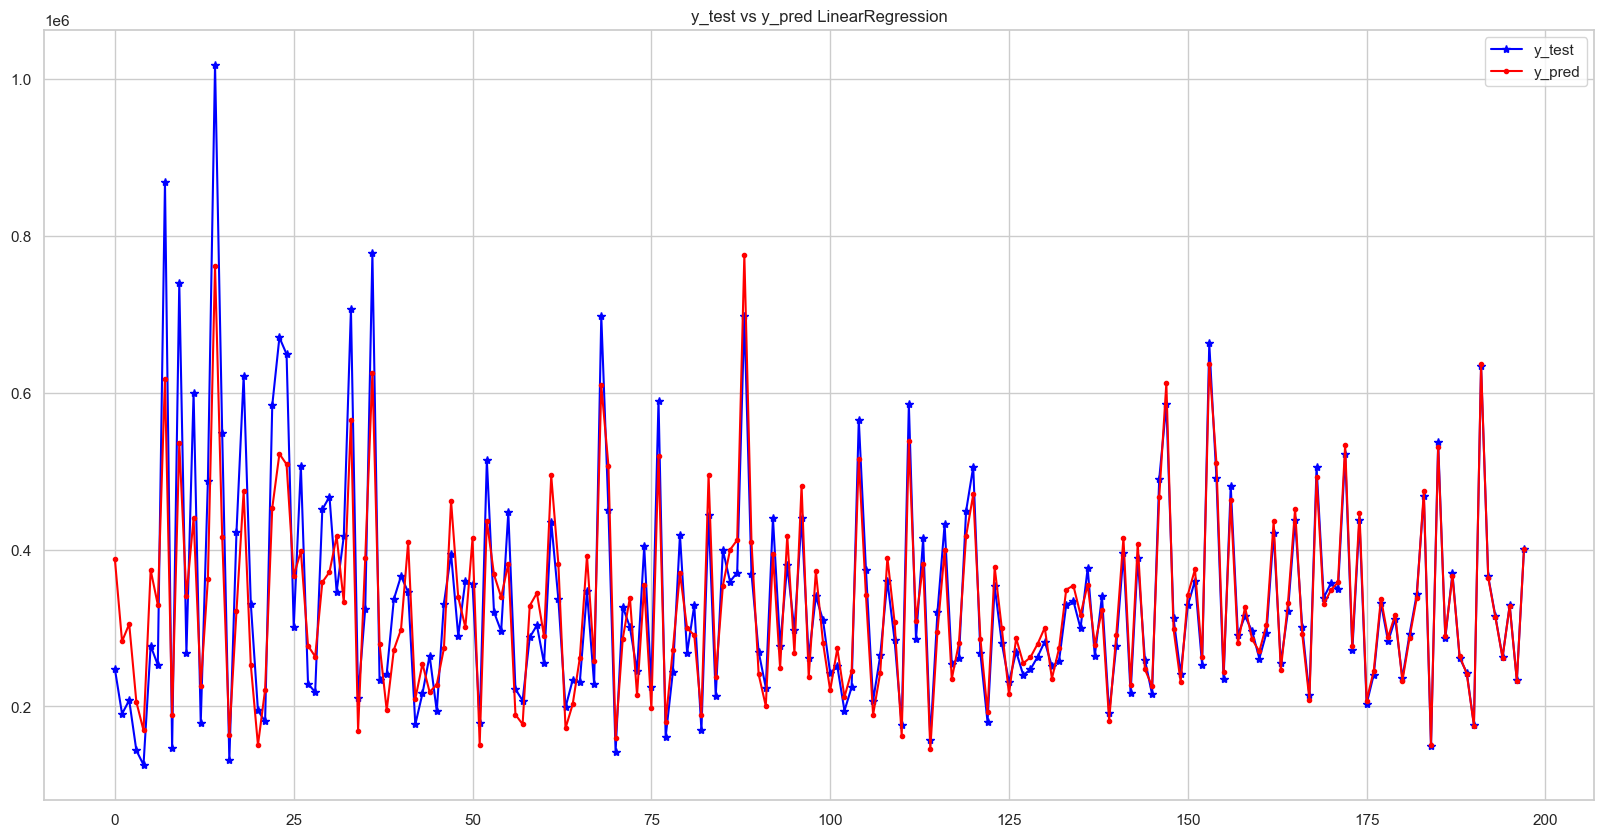

In [21]:
#remove the first two indexes
indexes = indexes[2:]
y_test_2 = y_test.iloc[indexes]
y_pred_2 = y_pred[indexes]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
indexes2 = visualize_test(y_test_2, y_pred_2, ax=axes, model_name='LinearRegression')
#Get the top 10% of those indices
top_10_percent_idx = indexes[:len(indexes) // 10]
# Extract rows from X_test and y_test using these indices
X_test_top_errors = X_test.iloc[top_10_percent_idx]
y_test_top_errors = y_test.iloc[top_10_percent_idx]

#Form a DataFrame
df_top_errors = pd.concat([X_test_top_errors, y_test_top_errors], axis=1)
df_top_errors.head()
df_top_errors.to_csv('top_errors.csv')

## Other models

After establishing a baseline model, we can proceed to test more complex models. Firstly, we conduct an initial round of model training, where we test various regression models using default parameters. The models we try out include: RandomForestRegressor, ElasticNet, Lasso, Ridge, DecisionTreeRegressor, KNeighborsRegressor, GradientBoostRegressor, AdaBoostRegressor, and CatBoostRegressor.

In addition to these models, we also experimented with others during training, such as MLP, SVR, naive Neural Networks, polynomial regressions, etc. However, these were not included in the notebook since their performance did not measure up to the models currently in the code.

Learning rate set to 0.081789
0:	learn: 0.3856475	total: 62.8ms	remaining: 1m 2s
1:	learn: 0.3627370	total: 67.3ms	remaining: 33.6s
2:	learn: 0.3416681	total: 71.7ms	remaining: 23.8s
3:	learn: 0.3225862	total: 75.9ms	remaining: 18.9s
4:	learn: 0.3053947	total: 80.2ms	remaining: 16s
5:	learn: 0.2898388	total: 84.3ms	remaining: 14s
6:	learn: 0.2755419	total: 88.3ms	remaining: 12.5s
7:	learn: 0.2621946	total: 92ms	remaining: 11.4s
8:	learn: 0.2508295	total: 96.1ms	remaining: 10.6s
9:	learn: 0.2402477	total: 99.7ms	remaining: 9.87s
10:	learn: 0.2300039	total: 103ms	remaining: 9.3s
11:	learn: 0.2211319	total: 107ms	remaining: 8.84s
12:	learn: 0.2131223	total: 111ms	remaining: 8.45s
13:	learn: 0.2061374	total: 115ms	remaining: 8.11s
14:	learn: 0.1995990	total: 119ms	remaining: 7.81s
15:	learn: 0.1936722	total: 123ms	remaining: 7.57s
16:	learn: 0.1881999	total: 127ms	remaining: 7.35s
17:	learn: 0.1829836	total: 131ms	remaining: 7.15s
18:	learn: 0.1783663	total: 135ms	remaining: 6.99s
19:	lear

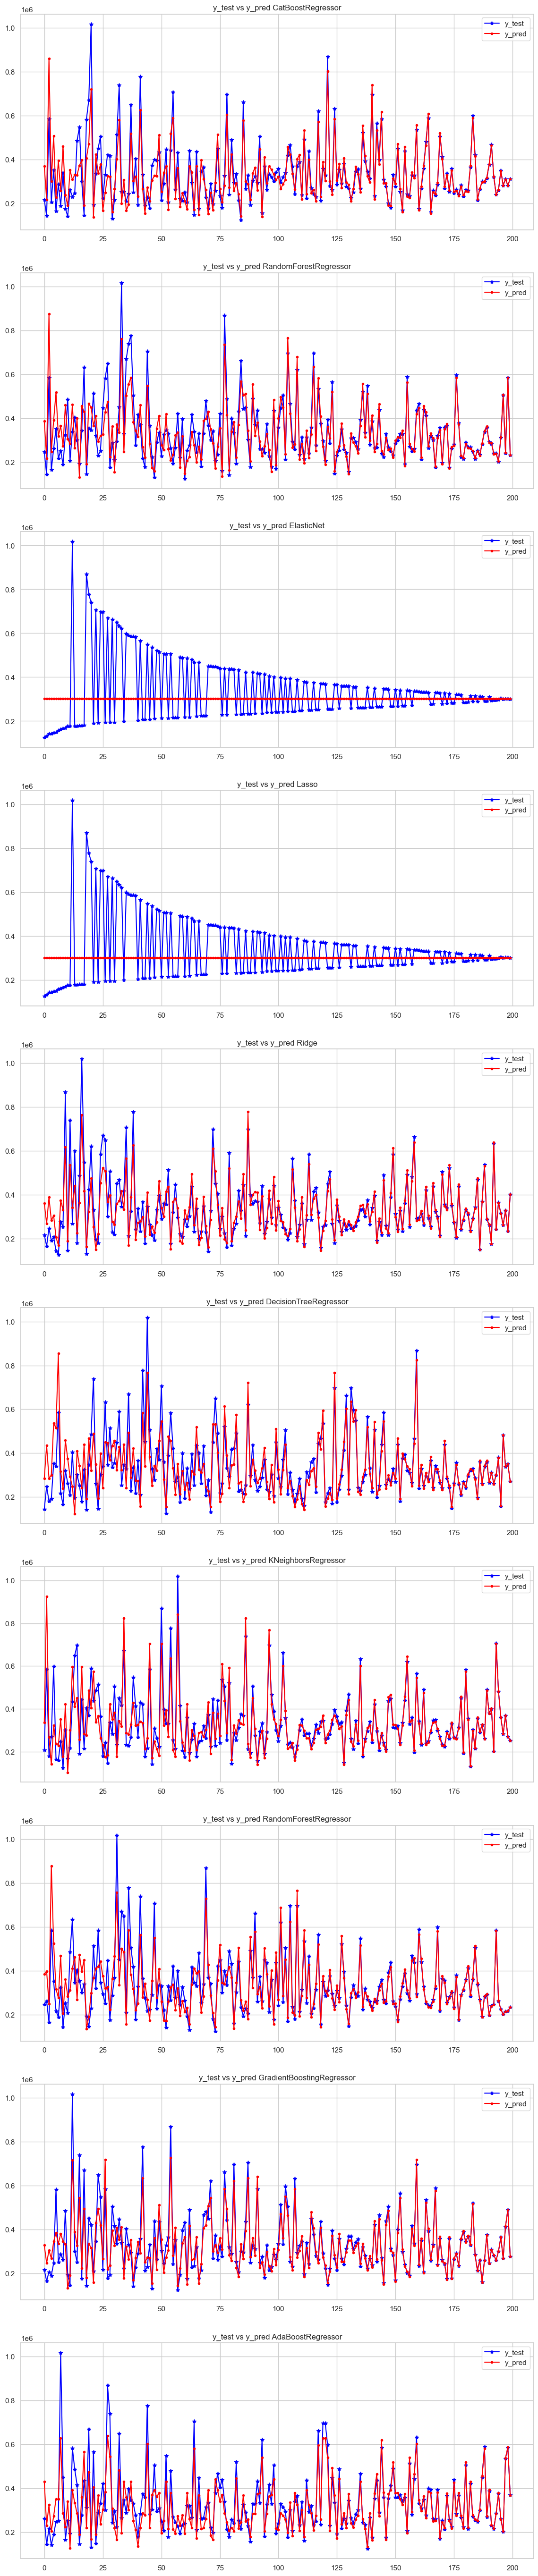

In [22]:
models = [CatBoostRegressor(), RandomForestRegressor(), ElasticNet(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor(n_neighbors=3, weights='distance'), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    y_pred = np.expm1(y_pred)

    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)
    
plt.show()

### Hyperparameter Tuning

Among the models that achieved the best results, we decided to optimize the hyperparameters for GradientBoostRegressor and CatBoostRegressor.

The code demonstrates how to use and improve a prediction model with CatBoost. CatBoost is a technique that relies on structures called "decision trees."

To start, we set a seed. This is done to ensure the results remain consistent every time we run the code.

A significant part of the code is dedicated to searching for the model's optimal settings. This is achieved using a tool called GridSearchCV. This tool tests different combinations and, through a process called "cross-validation," it determines the best one.

Finally, with the best settings identified, the model makes predictions on the test data. These predictions are then compared against actual data to assess how well the model performs.

The code is commented out since the execution time is quite long, and it's not necessary to run it to see the notebook's results.


In [23]:
#----------------------------------------
# CatBoostRegressor
#----------------------------------------

# catboost_regressor = CatBoostRegressor(
#     random_seed=0,  # Establece la semilla aleatoria
# )

# # Define tus hiperparámetros específicos de CatBoost
# param_grid = {
#     'depth': [6, 8, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'iterations': [500, 1000, 2000],
#     'l2_leaf_reg': [3, 5, 7],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bylevel': [0.7, 0.8, 0.9],
#     'border_count': [32, 64, 128]
# }

# # Realiza la búsqueda de hiperparámetros
# grid_search = GridSearchCV(catboost_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# # Obtiene el mejor modelo y los mejores hiperparámetros
# best_catboost_regressor = grid_search.best_estimator_
# best_param = grid_search.best_params_

# print(f"Mejores Hiperparámetros: {best_param}")

# y_pred = best_catboost_regressor.predict(X_test, y_test)

# y_pred = np.expm1(y_pred)
# indexes = visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

#----------------------------------------
# GradientBoostingRegressor
#----------------------------------------

# grad_boost = GradientBoostingRegressor()

# distributions = {
#     'learning_rate': uniform(0.01, 0.2),
#     'n_estimators': randint(100, 1000),
#     'max_depth': randint(3, 7),
#     'min_samples_split': uniform(0.01, 0.2),
#     'min_samples_leaf': uniform(0.01, 0.1),
#     'subsample': uniform(0.8, 0.2),
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=1000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
# search = clf.fit(X_train, y_train)
# search.best_params_

# Serializing the best model

Once we've identified the best hyperparameters for the model, we serialize it for use in future projects. For this, we utilize Python's pickle library. In this way, we can load the model to make predictions in the class competition.

Serialization is a process where we convert the model's structure and learned patterns into a format that can be saved to disk and then loaded back without having to retrain the model. Using pickle allows us to efficiently store the model and deploy it elsewhere or at a later time without the need for retraining. This is especially valuable for models that took a long time to train or when the training data is not readily available.

MAE: 40.37198943063253
MAPE: 11.79


Id
994    143
985     81
973    197
962    117
961    146
      ... 
23      74
21     199
16      63
11      78
8       55
Name: Precio, Length: 200, dtype: int64

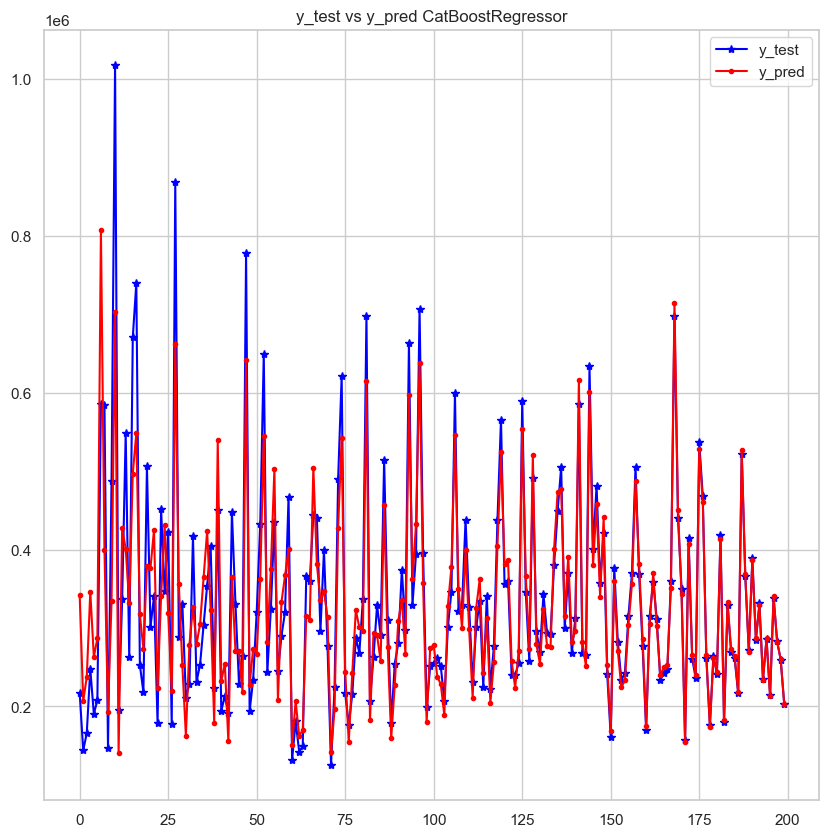

In [24]:
best_params = {'max_leaves': 8,
          'depth': 3,
          'od_wait': 200,
          'l2_leaf_reg': 3,
          'iterations': 200000,
          'model_size_reg': 0.7,
          'learning_rate': 0.05,
          'random_seed': 42 }

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
final_model = CatBoostRegressor(**best_params)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = final_model.predict(X_test)
y_pred = np.expm1(y_pred)

visualize_test(y_test, y_pred, ax=axes, model_name='CatBoostRegressor')

In [25]:
import pickle

with open("modelo.pickle", "wb") as handler:
    pickle.dump(final_model, handler)

# Conclusions

In conclusion, the models that achieved the lowest error were CatBoostRegressor and GradientBoostRegressor, which attain a MAPE of around 10-12% on the test set. Additionally, linear regression yields a MAPE between 11-13%, despite being a simpler model. This might be due to the presence of columns in the dataset that have a linear correlation with the price, allowing linear regression to effectively capture this relationship. Specifically, the column that most prominently demonstrates this phenomenon is aseos+hab*rating.

It's worth noting that the dataset we're using is relatively small, so the results can likely be improved with a larger dataset. As future work, it would be interesting to employ more sophisticated outlier detection methods to remove them from the training set, further enhancing model performance. Additionally, exploring more advanced normalization techniques for price or acquiring new data for model training could be beneficial.

# Bibliography

- [Article on class balancing in machine learning](https://proceedings.mlr.press/v74/branco17a/branco17a.pdf)
- [Random Oversampling and Undersampling for imbalanced classification](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)
- [Handling Imbalanced Data by Oversampling with SMOTE and its Variants](https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf)
- [Notes on handling skewed data](https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725)
- [Articles on skewed data](https://medium.com/tag/skewed-data)
- [Book: "An Introduction to Statistical Learning: with Applications in R" by James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013)](https://www.springer.com/gp/book/9781461471370)